In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import statistics 
import math


In [6]:
!pip install st-dbscan
from st_dbscan import ST_DBSCAN
!pip install geopy
import geopy.distance

In [7]:
df_fix = pd.read_csv("C:/Users/t480/Desktop/University courses/ENSAE 2A/STATAPP/Statapp-Hail-storm/bdd.csv")

In [8]:
def convert_time_to_timestamps(df):
    df['TIME_EVENT'] = pd.to_datetime(df['TIME_EVENT'],format = '%Y-%m-%d %H:%M:%S')
    df['TIME_EVENT'] = df.TIME_EVENT.values.astype(np.float64) # in nanoseconds
    df.TIME_EVENT = df.TIME_EVENT / (10 ** 9) # in seconds 
    df.TIME_EVENT = df.TIME_EVENT / 3600 # in hours
    return df

In [18]:
def getting_ready(df, country, year_since):
    df = convert_time_to_timestamps(df)
    df = df[df['COUNTRY'] == country]
    df = df[df['YEAR'] >= year_since]
    df = df[['TIME_EVENT', 'LATITUDE', 'LONGITUDE']]
    df = df.reset_index(drop=True)
    return df 

In [10]:
def run_dbscan_retrieve_classes(df, spatial_th, time_th, min_sample):
    model = ST_DBSCAN(eps1=spatial_th, eps2=time_th, min_samples=min_sample)
    fit = model.fit(df) 
    labels = pd.DataFrame(model.labels)
    df['LABELS'] = labels
    return df

In [115]:
df = df_fix.copy()
df

,Unnamed: 0,LATITUDE,LONGITUDE,TIME_EVENT,COUNTRY,YEAR
0,0,45.567,5.933,2022-10-24 10:15:00,FR,2022
1,1,45.596,5.875,2022-10-24 09:52:00,FR,2022
2,2,50.967,2.667,2022-10-23 17:00:00,BE,2022
3,3,51.000,2.700,2022-10-23 17:00:00,BE,2022
4,4,49.583,1.358,2022-10-23 16:30:00,FR,2022
...,...,...,...,...,...,...
43607,43607,48.750,7.100,2007-02-11 15:10:00,FR,2007
43608,43608,52.150,14.650,2007-01-18 19:00:00,DE,2007
43609,43609,52.083,10.333,2007-01-18 17:10:00,DE,2007
43610,43610,43.600,39.730,2007-01-16 02:00:00,RU,2007


In [116]:
country = 'FR'
year_since = 2022
df = getting_ready(df, country, year_since)
df

,TIME_EVENT,LATITUDE,LONGITUDE
0,462946.250000,45.567,5.933
1,462945.866667,45.596,5.875
2,462928.500000,49.583,1.358
3,462928.416667,49.533,1.267
4,462928.383333,49.521,1.251
...,...,...,...
1975,458531.666667,43.279,2.460
1976,458514.500000,44.600,-0.933
1977,458174.283333,48.669,5.114
1978,458174.166667,48.636,4.952


Visualising the timing of reports with an intensity map 

In [111]:
def visualise_biggest(df, n_biggest):

    nb_reports = pd.DataFrame(df['LABELS'].value_counts()).reset_index()
    nb_reports = nb_reports[nb_reports['index'] != -1].sort_values('LABELS', ascending=False).reset_index()
    labels_biggest_storms = list(nb_reports.iloc[0:3,1])
    df_biggest = df.loc[df.LABELS.isin(labels_biggest_storms)]

    # plots the n_biggest storms 
    plt.figure(figsize=(10,6))
    for i in range(n_biggest):
        a = df_biggest.LONGITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        b = df_biggest.LATITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        lab = df_biggest.loc[df_biggest.LABELS == labels_biggest_storms[i]]
        plt.scatter(a, b, c='C{}'.format(i), label='{} most reported storm'.format(i+1))
    plt.ylabel('latitude')
    plt.xlabel('longitude')
    plt.legend()
    plt.title("The {} biggest storms in terms of report counts".format(len(labels_biggest_storms)))
    plt.show()

    # plot timing of storms in latlon
    for i in range(n_biggest):
        x = df_biggest.LONGITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        y = df_biggest.LATITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        z = df_biggest.TIME_EVENT[df_biggest.LABELS == labels_biggest_storms[i]]
        z = z - z.iloc[-1]
        x = x.array
        y = y.array
        z = z.array
        axis = plt.subplot(111, title="Storm with {} reports".format(len(x)))
        sc = axis.scatter(x, y, c=z, marker=".")
        plt.colorbar(sc, label="duration of the storm (in hours)")
        plt.show()
        # distance between first and last reports
        df_distance = df_biggest[df_biggest.LABELS==labels_biggest_storms[i]].sort_values('TIME_EVENT')
        df_distance = df_distance.reset_index(drop=True)
        latbegin = df_distance.LATITUDE[0]
        latend = df_distance.LATITUDE[len(df_distance.LATITUDE)-1]
        lonbegin = df_distance.LONGITUDE[0]
        lonend = df_distance.LONGITUDE[len(df_distance.LONGITUDE)-1]
        coords_1 = (latbegin, lonbegin)
        coords_2 = (latend, lonend)
        dist = geopy.distance.geodesic(coords_1, coords_2).km
        print("The storm has length",dist,"km between first report and last report")


    return df

In [103]:
df1 = run_dbscan_retrieve_classes(df, 0.2, 2, 2)

In [109]:
nb_reports = pd.DataFrame(df['LABELS'].value_counts()).reset_index()
nb_reports = nb_reports[nb_reports['index'] != -1].sort_values('LABELS', ascending=False).reset_index()
labels_biggest_storms = list(nb_reports.iloc[0:3,1])
print('The storm with most reports is number', labels_biggest_storms[0])
    
df_biggest = df.loc[df.LABELS.isin(labels_biggest_storms)]


The storm with most reports is number 102


In [100]:
df.sort_values('LABELS')

,TIME_EVENT,LATITUDE,LONGITUDE,LABELS
1979,457481.000000,44.750,-0.533,-1
661,460073.133333,46.692,4.546,-1
662,460072.950000,46.607,4.359,-1
679,460018.550000,44.350,6.360,-1
680,460018.233333,43.983,5.567,-1
...,...,...,...,...
1974,458531.666667,43.270,2.436,158
1975,458531.666667,43.279,2.460,158
1970,458532.083333,43.316,2.637,158
1978,458174.166667,48.636,4.952,159


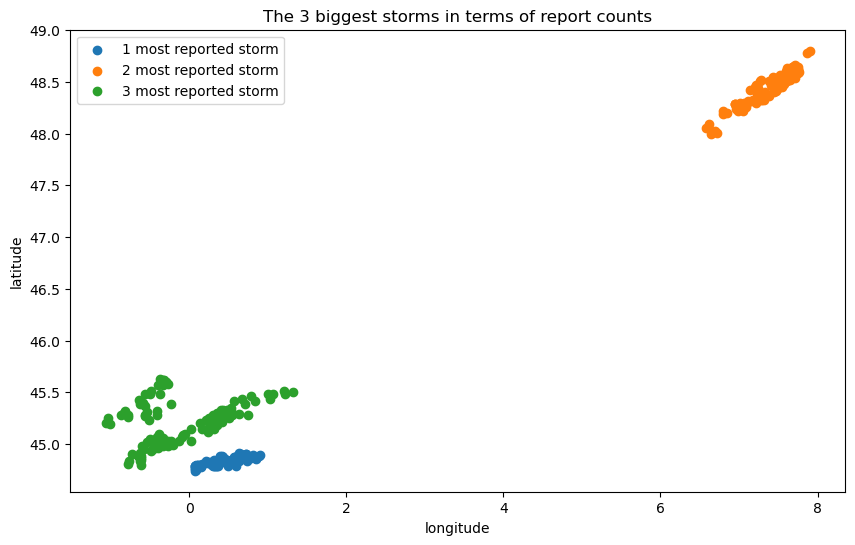

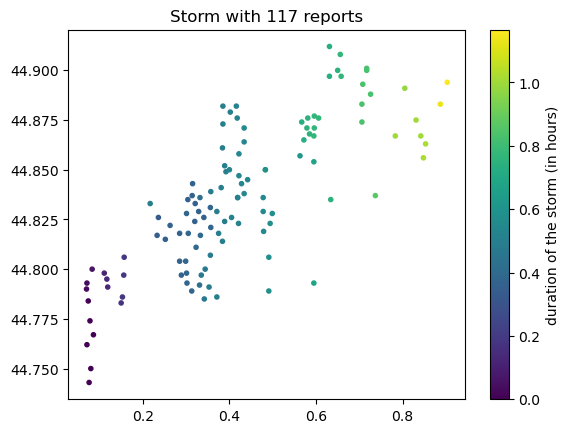

The storm has length 67.52959590342745 km between first report and last report


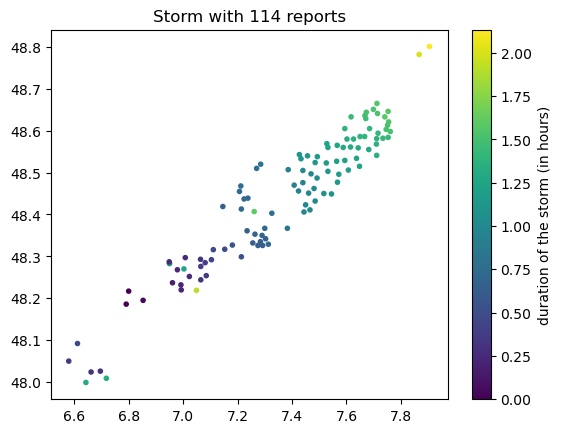

The storm has length 104.32207762462274 km between first report and last report


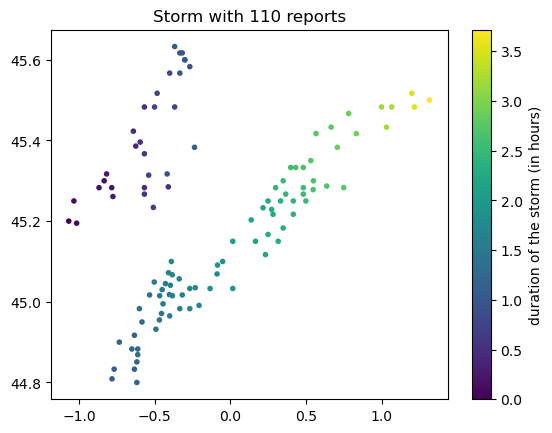

The storm has length 189.76721988809064 km between first report and last report


,TIME_EVENT,LATITUDE,LONGITUDE,LABELS
0,462946.250000,45.567,5.933,0
1,462945.866667,45.596,5.875,0
2,462928.500000,49.583,1.358,1
3,462928.416667,49.533,1.267,1
4,462928.383333,49.521,1.251,1
...,...,...,...,...
1975,458531.666667,43.279,2.460,170
1976,458514.500000,44.600,-0.933,-1
1977,458174.283333,48.669,5.114,171
1978,458174.166667,48.636,4.952,171


In [121]:
df1 = run_dbscan_retrieve_classes(df, 0.2, 2, 2)
visualise_biggest(df1,3)

Inspecting information gains from changing parameters 

The storm with most reports is number 163


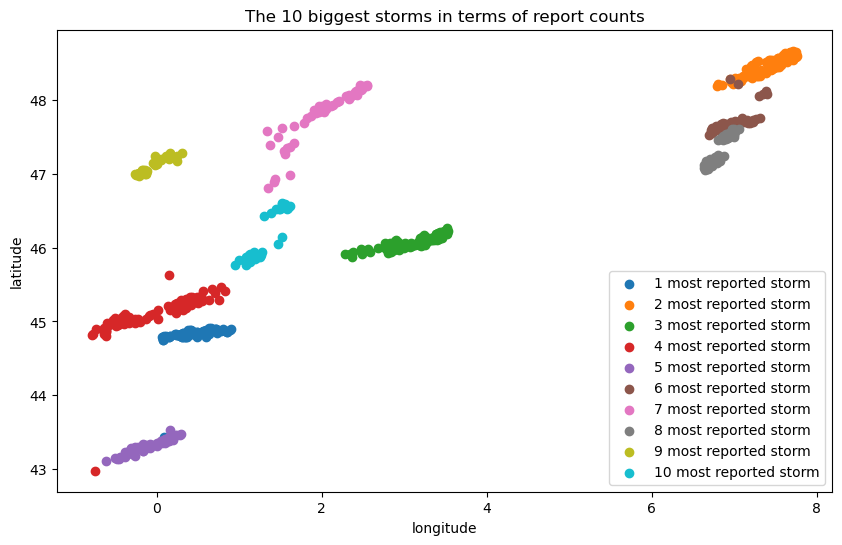

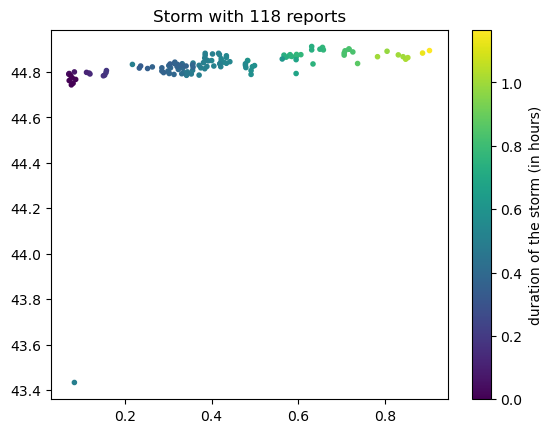

The storm has length 67.52959590342745 km between first report and last report


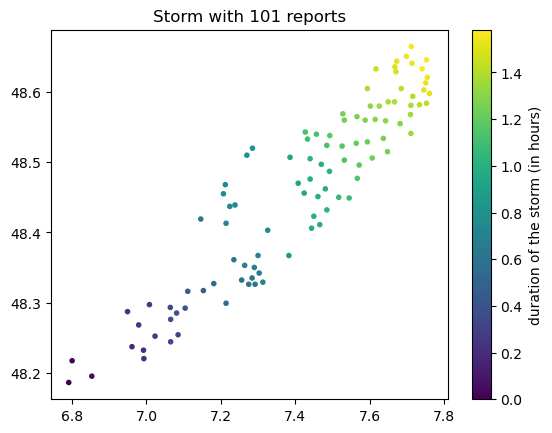

The storm has length 83.60590742857576 km between first report and last report


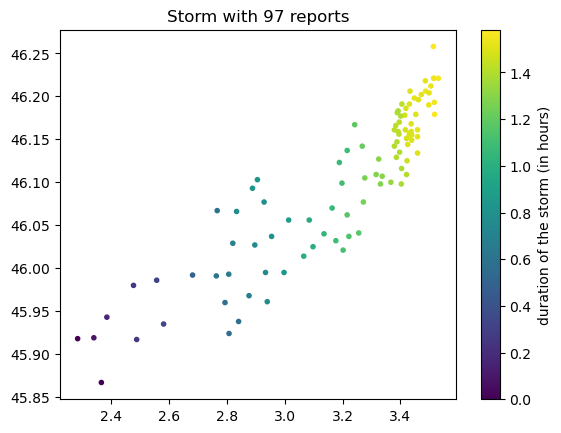

The storm has length 98.81892212115582 km between first report and last report


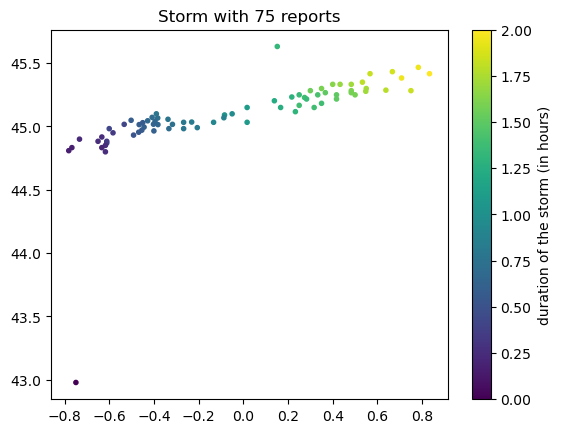

The storm has length 299.0503377437093 km between first report and last report


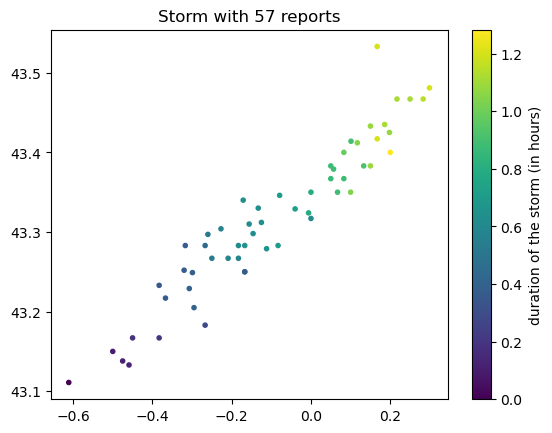

The storm has length 73.26456217782946 km between first report and last report


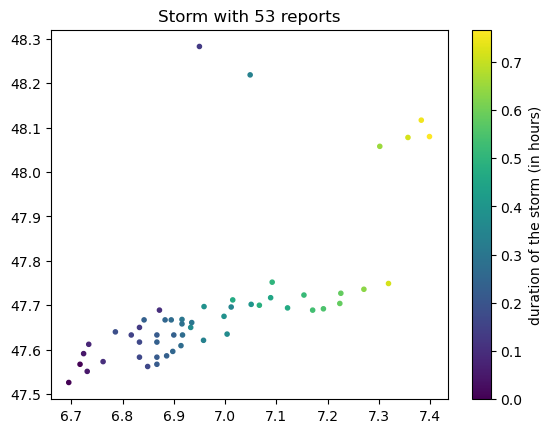

The storm has length 81.08754056440917 km between first report and last report


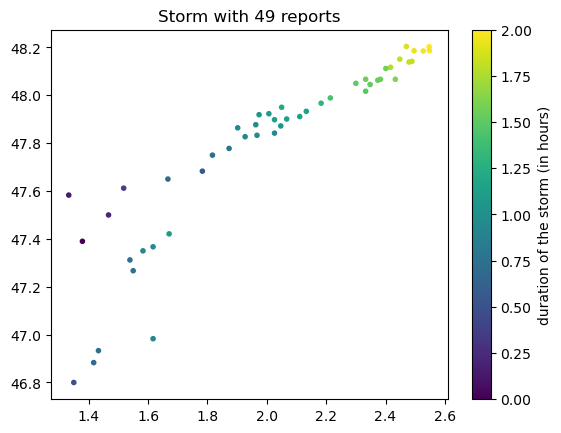

The storm has length 125.80734099363637 km between first report and last report


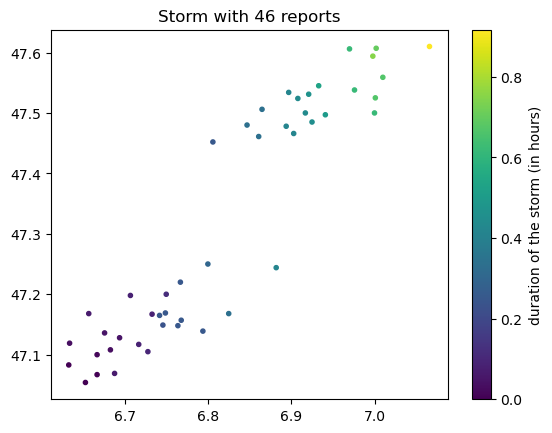

The storm has length 69.24916081319792 km between first report and last report


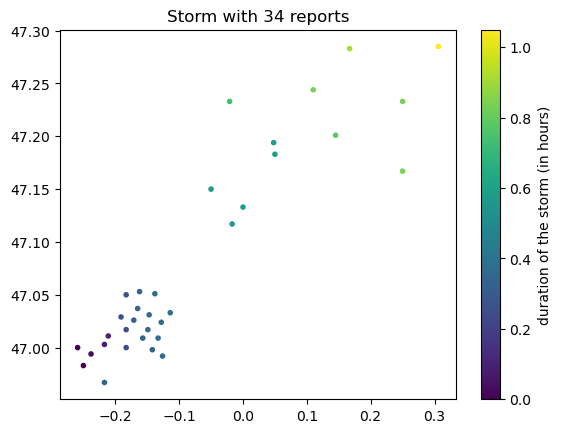

The storm has length 53.29752003913894 km between first report and last report


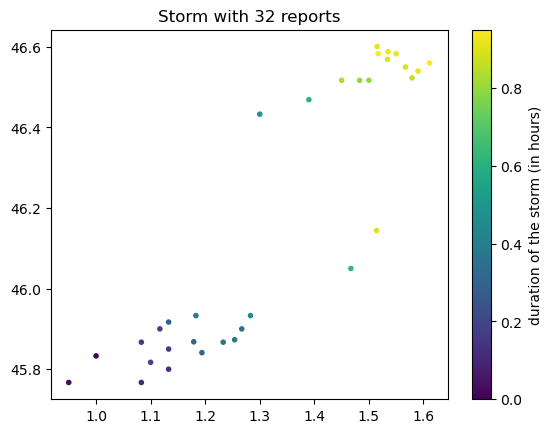

The storm has length 92.42154799399735 km between first report and last report


,LATITUDE,LONGITUDE,TIME_EVENT,LABELS
0,45.567,5.933,462946.250000,-1
1,45.596,5.875,462945.866667,-1
2,49.583,1.358,462928.500000,0
3,49.533,1.267,462928.416667,0
4,49.521,1.251,462928.383333,0
...,...,...,...,...
1975,43.279,2.460,458531.666667,192
1976,44.600,-0.933,458514.500000,-1
1977,48.669,5.114,458174.283333,193
1978,48.636,4.952,458174.166667,193


In [147]:
df = run_dbscan_retrieve_classes(df, 0.2, 2, 2)
visualise_biggest(df,10)

Explore bin cluster (percentage of reports we manage to cluster)

Run DBSCAN over since 2013 and compare the result